# Predicting Electricity consumption

## Team
Dmitri Rozgonjuk <br>
Eerik Sven Puudist <br>
Triin Pohla  <br>
Andri Hõbemägi <br>

## 0. Setup
Libraries

In [1]:
# Dataframes and vector ops
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# MISC
import json # used for 'holidays' extraction
import requests # used for 'holidays' extraction

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Import and a Quick Glimpse
The original data set is from aggle, and the below code could be uncommented in order to download that data, unzip the file, and import the data tables that invlude training, test, and submissions data file. The submissions data file is a sample submission for testing that the data are submitted to Kaggle in the appropriate format.

In [2]:
# Download data from kaggle
#!kaggle competitions download -c predict-electricity-consumption

# Unzip the data
#!unzip predict-electricity-consumption.zip

In [3]:
# Import the data
df_train = pd.read_csv("data/train.csv")
# Rename 'consumption' to 'y_original'
df_train = df_train.rename(columns = {'consumption': 'y_original'})

df_test = pd.read_csv("data/test.csv")
df_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
print(f'Dimensions of training data: {df_train.shape}')
print(f'Earliest timepoint (training data): {min(df_train["time"])}')
print(f'Latest timepoint (training data): {max(df_train["time"])}')
df_train.head()

Dimensions of training data: (8592, 13)
Earliest timepoint (training data): 2021-09-01 00:00:00+03:00
Latest timepoint (training data): 2022-08-24 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,y_original
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


In [5]:
print(f'Dimensions of test data: {df_test.shape}')
print(f'Earliest timepoint (test data): {min(df_test["time"])}')
print(f'Latest timepoint (test data): {max(df_test["time"])}')
df_test.head()

Dimensions of test data: (168, 12)
Earliest timepoint (test data): 2022-08-25 00:00:00+03:00
Latest timepoint (test data): 2022-08-31 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192


## 2. Data Preprocessing
In this section, we are extracting information from available data. Additionally, here is where we implement data transformations and prepare the final datasets for use in models.

### 2.1. Extracting Features from `time` Column
Before we start extracting information from the `time` variable, we first need to convert the column to a `datetime64` type in pandas. Then, we should look into the time range of each data set. The goal is to see what were the date ranges (for extracting additional features, e.g., holidays), and to see if the test data immediately follows training data in time sequence.

In [6]:
# Transform the 'time' column to a `datetime` format 
df_train['time'] = pd.to_datetime(df_train['time'], utc=True)
df_test['time'] = pd.to_datetime(df_test['time'], utc=True)
df_submission['time'] = pd.to_datetime(df_submission['time'], utc=True)

In [7]:
print(f"The range of training data: {df_train['time'].min(), df_train['time'].max()}")
print()
print(f"The range of test data: {df_test['time'].min(), df_test['time'].max()}")

The range of training data: (Timestamp('2021-08-31 21:00:00+0000', tz='UTC'), Timestamp('2022-08-24 20:00:00+0000', tz='UTC'))

The range of test data: (Timestamp('2022-08-24 21:00:00+0000', tz='UTC'), Timestamp('2022-08-31 20:00:00+0000', tz='UTC'))


Ok, from this we see that, indeed, the training and test data are sequential. The training dates range from 31.08.2021 to 24.08.2022, while the range for test data is 24.08.2022 until 31.08.2022. Now, we will also download the Estonian holidays table and keep only the rows for the relevant time period. (Let's also save the holidays table in case we need to use this in the future.)

In [8]:
# NOTE! Also possible to fetch the holidays info via 'holidays' Python module

# Fetch the list of holidays from 'riigipühad.ee'
r = requests.get('https://riigipühad.ee/?output=json')
json_str = json.dumps(r.json())
holidays = pd.read_json(json_str)
holidays['time'] = pd.to_datetime(holidays['date'], utc=True)
holidays['date'] = holidays['time'].dt.date

# Replace the values for holiday kind (to cat, and more readablity)
## 1 = 'Riigipüha' = '1_sthol' # state holiday
## 2 = 'Rahvuspüha' = '2_nathol' # national holiday
## 3 = 'Riiklik tähtpäev' = '3_natday' # nationally celebrated day
## 4 = 'Lühendatud tööpäev' = '4_shortday' # shortened day before holiday
holidays['kind_id'] = holidays['kind_id'].astype(str)
holidays['kind_id'] = holidays['kind_id'].str.replace('1', '1_sthol')
holidays['kind_id'] = holidays['kind_id'].str.replace('2', '2_nathol')
holidays['kind_id'] = holidays['kind_id'].str.replace('3', '3_natday')
holidays['kind_id'] = holidays['kind_id'].str.replace('4', '4_shortday')

In [9]:
holidays.rename(columns= {'kind_id':'h_type'}, inplace = True) # rename the col for later clarity
# holidays.to_csv('estonian_holidays.csv', index=False)

# Keep only the relevant rows
holidays = holidays[(holidays['date'] >= df_train['time'].dt.date.min()) & 
                    (holidays['date'] <= df_test['time'].dt.date.max())].reset_index(drop = True)
holidays.head()
# holidays['kind_id'].value_counts() # count the unique holiday types

# Create the mini df for merge
df_holidays = holidays.loc[:, ['date', 'h_type']]
df_holidays['is_holiday'] = np.full(len(df_holidays), 'hol')
df_holidays.head()

# might be useful for calendar data: https://towardsdatascience.com/holiday-calendars-with-pandas-9c01f1ee5fee

,date,h_type,is_holiday
0,2021-09-12,3_natday,hol
1,2021-09-22,3_natday,hol
2,2021-10-16,3_natday,hol
3,2021-11-02,3_natday,hol
4,2021-11-14,3_natday,hol


Below, we are creating a helper function that extract date-related information

In [10]:
### 2.1. Create meaningful variables from 'time'
def wrangle_dates(df):
    """A function that turns a pd.Series datetime column to several more granular columns
    Args:
        df (pandas DataFrame): input data (e.g., df_train or df_test)
    """
    # Date variables
    df['date'] = df['time'].dt.date # date
    df['year'] = df['time'].dt.year # year
    df['month'] = df['time'].dt.month # month
    df['dow'] = df['time'].dt.dayofweek # day-of-week
    df['dayname'] = df['time'].dt.day_name() # dayname
    df['weekend'] = 'no'

    # update weekend column values if it's a weekend day
    for i in range(len(df)):
        if df['dow'][i] in [5,6]:
            df['weekend'][i] = 'yes'
            
    # Time variables
    ## Only the 'hour' varies, hence no need for 'time' and 'minute'
    df['hour'] = df['time'].dt.hour.astype(int) # hour
    
    # Season
    conditions = [
        (df['month'].isin(np.arange(3,6))), (df['month'].isin(np.arange(6,9))), 
        (df['month'].isin(np.arange(9,12))), (df['month'].isin(np.arange(1,3))), (df['month'] == 12)]
    choices = ['Spring','Summer', 'Autumn', 'Winter', 'Winter']
    df['season'] = np.select(conditions, choices)
    
    # Remove the `time` variable, as it is not needed anymore
    #df = df.drop(columns = ['time'], axis = 1)
    

In [11]:
wrangle_dates(df_train)

# Add holidays info
df_train = df_train.merge(df_holidays, on = 'date', how = 'left')
df_train['h_type'] = df_train['h_type'].fillna('not_hol').astype(str)
df_train['is_holiday'] = df_train['is_holiday'].fillna('not_hol').astype(str)

# Custom fill for `snow` (fill with the next non-NaN value)
snow = df_train['snow'].to_numpy()
snow_index = df_train.index[~df_train['snow'].isna()].tolist()
current_snow_value = 0
for i in range(len(snow)):
    if i > 5241:
        current_snow_value = 0
        snow[i] = current_snow_value
    if i not in (snow_index):
        snow[i] = current_snow_value
    if i in (snow_index):
        current_snow_value = snow[i]
        snow[i] = current_snow_value
df_train['snow'] = snow

# Fill `prcp` with 0
df_train['prcp'] = df_train['prcp'].fillna(0.0)

# Fill NAs with last valid values, convert `coco` to categorical
df_train['coco'].fillna(method = 'ffill', inplace = True)
df_train['coco'] = df_train['coco'].astype(str)

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,date,year,month,dow,dayname,weekend,hour,season,h_type,is_holiday
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,2021-08-31,2021,8,1,Tuesday,no,21,Summer,not_hol,not_hol
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,2021-08-31,2021,8,1,Tuesday,no,22,Summer,not_hol,not_hol
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,2021-08-31,2021,8,1,Tuesday,no,23,Summer,not_hol,not_hol
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,2021-09-01,2021,9,2,Wednesday,no,0,Autumn,not_hol,not_hol
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,2021-09-01,2021,9,2,Wednesday,no,1,Autumn,not_hol,not_hol


In [12]:
wrangle_dates(df_test)

# Add holidays info
df_test = df_test.merge(df_holidays, on = 'date', how = 'left')
df_test['h_type'] = df_test['h_type'].fillna('not_hol').astype(str)
df_test['is_holiday'] = df_test['is_holiday'].fillna('not_hol').astype(str)

# Fill `snow` with 0 (no snow in August)
df_test['snow'] = df_test['snow'].fillna(0.0)

# Fill `prcp` with 0
df_test['prcp'] = df_test['prcp'].fillna(0.0)
df_test.head()

# Fill NAs with last valid values, convert `coco` to categorical
df_test['coco'].fillna(method = 'ffill', inplace = True)
df_test['coco'] = df_test['coco'].astype(str)

## 2.1. `consumption` transformations
This is our target variable. Here, we first impute the few missing data points by using interpolation - in essence, this is the value of average of the previous and next time point.

In [13]:
# Fill the NAs with the average of previous and next value in time-series
df_train['y_imp'] = df_train['y_original'].interpolate()

# Add a constant to avoid '0.0'
df_train['y_imp'] = df_train['y_imp'] + 0.000001

We also need to take care of the outliers. To that end, let's explore some potential autocorrelation values and, based on that, adjsut the values with a N-day moving average. First, let's compute a vector of autocorrelations. this should help us with selecting how many shifts would be reasonable for predictions.

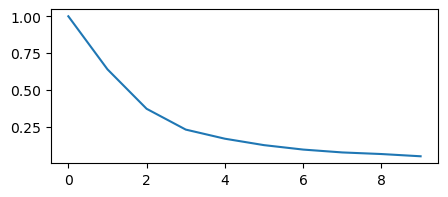

In [14]:
autocors = [df_train['y_imp'].autocorr(i) for i in range(10)]

plt.figure(figsize=[5,2])
plt.plot(autocors)
plt.show();

The figure above shows that perhaps it makes sense to compute the rolling means up for three days the most, as after that the autocorrelation gets too low.

In [15]:
# Compute new values: rolling means over 2 and 3 days
## Fill the NAs of N rows (N = size of rolling window) with the original values
df_train['y_imp_r2'] = df_train['y_imp'].rolling(2).mean()
nan_idx = df_train[df_train['y_imp_r2'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r2'] = df_train.loc[nan_idx.values, 'y_imp_r2'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

df_train['y_imp_r3'] = df_train['y_imp'].rolling(3).mean()
nan_idx = df_train[df_train['y_imp_r3'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r3'] = df_train.loc[nan_idx.values, 'y_imp_r3'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

# There's really no point to compute the 7- or 14-hour rolling averages
#df_train['y_imp_r7'] = df_train['y_imp'].rolling(3).mean()
#df_train['y_imp_r7'] = df_train['y_imp_r7'].fillna(df_train['y_imp'])

#df_train['y_imp_r14'] = df_train['y_imp'].rolling(3).mean()
#df_train['y_imp_r14'] = df_train['y_imp_r14'].fillna(df_train['y_imp'])

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,dow,dayname,weekend,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,1,Tuesday,no,21,Summer,not_hol,not_hol,0.577001,0.577001,0.577001
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,1,Tuesday,no,22,Summer,not_hol,not_hol,0.594001,0.585501,0.594001
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,1,Tuesday,no,23,Summer,not_hol,not_hol,0.685001,0.639501,0.618668
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,2,Wednesday,no,0,Autumn,not_hol,not_hol,1.016001,0.850501,0.765001
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,2,Wednesday,no,1,Autumn,not_hol,not_hol,0.677001,0.846501,0.792668


Let's take a look at the different rolling means values:

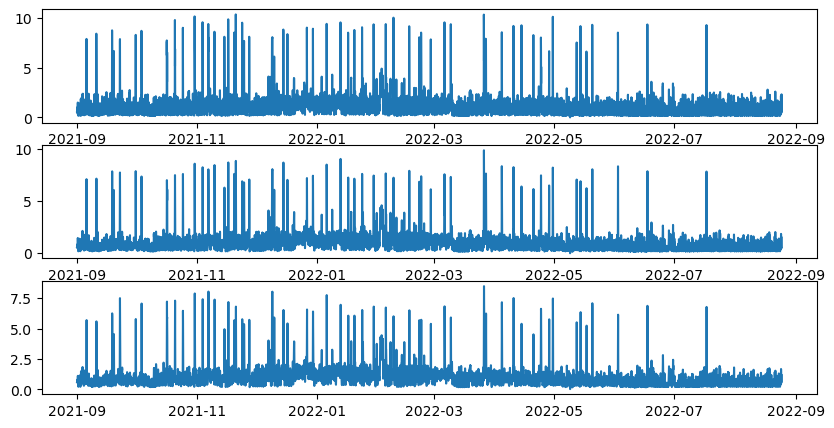

In [16]:
fig, (ax1, ax2, ax3, #ax4, ax5
     ) = plt.subplots(nrows = 3, #5, 
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp'])
ax2.plot(df_train['time'], df_train['y_imp_r2'])
ax3.plot(df_train['time'], df_train['y_imp_r3'])
#ax4.plot(df_train['time'], df_train['y_imp_r7'])
#ax5.plot(df_train['time'], df_train['y_imp_r14'])
plt.show();

There is still some a significant intra-day variation that results in spikes in the graphs. Let's try to further smooth these spikes by applying log-normalization. Let's then plot the results. Note: when predicting the values, make sure to exponentiate the predictions!

In [17]:
df_train['y_imp_log'] = np.log(df_train['y_imp'])
df_train['y_imp_r2_log'] =  np.log(df_train['y_imp_r2'])
df_train['y_imp_r3_log'] = np.log(df_train['y_imp_r3'])
#df_train['y_imp_r7_log'] =  np.log(df_train['y_imp_r7'])
#df_train['y_imp_r14_log'] =  np.log(df_train['y_imp_r14'])
df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3,y_imp_log,y_imp_r2_log,y_imp_r3_log
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,21,Summer,not_hol,not_hol,0.577001,0.577001,0.577001,-0.549911,-0.549911,-0.549911
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,22,Summer,not_hol,not_hol,0.594001,0.585501,0.594001,-0.520874,-0.535287,-0.520874
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,23,Summer,not_hol,not_hol,0.685001,0.639501,0.618668,-0.378335,-0.447067,-0.480187
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,0,Autumn,not_hol,not_hol,1.016001,0.850501,0.765001,0.015874,-0.161930,-0.267878
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,1,Autumn,not_hol,not_hol,0.677001,0.846501,0.792668,-0.390083,-0.166644,-0.232351


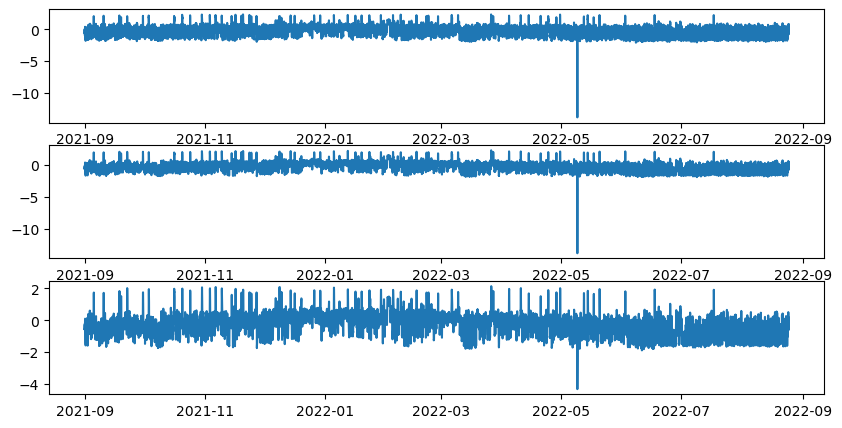

In [18]:
fig, (ax1, ax2, ax3, 
      #ax4, ax5
     ) = plt.subplots(nrows = 3, # 5,
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp_log'])
ax2.plot(df_train['time'], df_train['y_imp_r2_log'])
ax3.plot(df_train['time'], df_train['y_imp_r3_log'])
#ax4.plot(df_train['time'], df_train['y_imp_r7_log'])
#ax5.plot(df_train['time'], df_train['y_imp_r14_log'])
plt.show();

Additional target variables where the values are between M +- 2SD.

As an intermediate step, let's test these datasets by writing them out first

In [19]:
df_train.to_csv('data/df_train_DR2.csv')
df_test.to_csv('data/df_test_DR2.csv')

In [20]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

## 3. Describing the Associations between the Features and Target
Let's look at the correlations between the numeric variables

In [ ]:
cors = df_train.drop(columns = ['year']).corr()
sns.heatmap(cors, vmin = -1, vmax = 1)
plt.show();

Energy consumption across various time metrics

In [ ]:
def hourly_consumption_hmap(grouping_var, y_var, title):
    df = df_train.loc[:, [grouping_var, 'hour', y_var]].\
    groupby([grouping_var, 'hour']).mean(y_var).reset_index().\
    pivot('hour', grouping_var, y_var)
    
    # Plot
    sns.heatmap(df)
    plt.title(f'Average Energy Consumption ({title} x Time of Day)')
    plt.show();

In [ ]:
hourly_consumption_hmap('dow', 'y_imp', 'Day of Week')
hourly_consumption_hmap('month', 'y_imp', 'Month')
hourly_consumption_hmap('season', 'y_imp', 'Season')
hourly_consumption_hmap('h_type', 'y_imp', 'Holiday Type')

## Predicting Energy Consumption

Splitting the data to training, validation, and test splits

In [ ]:
# Separate X features and target

## Data to be split
### Remove unnecessary columns, impute NaNs
y_training =  df_train['consumption']
X_training = df_train.drop(columns = ['consumption', 'time', 'date'])
## Test data (used for predictions)
X_test = df_test.drop(columns = ['time', 'date'])


# Experiment with dropping the columns with a lot of missing values
# X_train.isnull().sum()
X_training = X_training.drop(columns = ['prcp', 'snow', 'coco'])
X_test = X_test.drop(columns = ['prcp', 'snow', 'coco'])

In [ ]:
# Splits
## Training data
X_train = X_training.iloc[len(X_training)-1000:,:]
y_train = y_training[len(y_training)-1000:]

## Validation data
X_val = X_training.iloc[:len(X_training)-1000,:]
y_val = y_training[:len(X_training)-1000]

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_val.shape, y_val.shape

## Data Preprocessing

In [ ]:
# https://lifewithdata.com/2022/03/09/onehotencoder-how-to-do-one-hot-encoding-in-sklearn/

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
ohe = OneHotEncoder(sparse = False)
bla = ohe.fit_transform(X_train)

In [ ]:
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
cat_cols

In [ ]:
# pipeline for numerical columns
num_pipe = make_pipeline(
    StandardScaler()
)

# pipeline for categorical columns
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

In [ ]:
adaboost = make_pipeline(full_pipe, AdaBoostRegressor(n_estimators=100, random_state=0))

In [ ]:
adaboost.fit(X_train, y_train)

## A naive ML-based approach

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
cv = RepeatedKFold(n_splits=3, n_repeats=1) # can be also adjusted!
model = RandomForestRegressor().fit(X_train, y_train)
cross_val_score(model, X_val, y_val, cv = cv).mean()

## HPO

In [ ]:
# !pip install git+https://github.com/hyperopt/hyperopt-sklearn
from hpsklearn import HyperoptEstimator, any_regressor, any_preprocessing, normalizer, lasso
from hyperopt import tpe

## Scikit-Optimize

In [ ]:
# https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

# !pip install scikit-optimize
from skopt import Optimizer

## The ARIMA approach
For this approach, we used the [helpful tutorial](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7) for guidance.

For this approach, we need to take into account the three components of a time series:
* **Trend**: the movement of data over a larger time interval
* **Seasonality**: variance within smaller time intervals
* **Noise**: random variations

Before building the model, we need to ensure the stationarity of the time series. In other words, the average od the time series should not be a function of time.


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Let's plot the original time series in training data

In [ ]:
plt.figure(figsize=[16,4])
plt.plot(X_train['time'], y_train)
plt.show();

Yikesy-spikesy. Let's test the data for stationarity.

In [ ]:
result = adfuller(y_train)
print('ADF Statistic: {}'.format(result[0]))

print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

To this end, the data seem to be stationary.

In [ ]:
np.seterr(divide = 'ignore') 
df_log = np.log(y_train)




plt.figure(figsize=[16,4])
plt.plot(df_log)
plt.show();

In [ ]:
plt.plot((y_train - np.min(y_train))/(np.max(y_train)/np.min(y_train)))